In [1]:
import os
import sys
import gzip
import gpxpy
import shutil
import fitdecode
import gpxpy.gpx
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

import parse_fit
import parse_gpx
import parse_tcx

pd.options.display.max_columns = 100

%load_ext autoreload
%autoreload 2

In [2]:
list_of_fit_files = ["\\".join((".\\data", v)) for v in os.listdir(".\\data")
                     if ".gpx" not in v and ".gz" not in v]
list_of_gpx_files = ["\\".join((".\\data", v)) for v in os.listdir(".\\data")
                     if ".gpx" in v]

In [3]:
# SAVE FILES TO AVOID RECOMPUTING EACH TIME
fit_file_laps = pd.read_parquet(".\\data\\fit_file_laps.parquet")
fit_file_points = pd.read_parquet(".\\data\\fit_file_points.parquet")

In [4]:
def compute_power(weight, bike_wgt, speed, slope):
    
    # 1) rolling resistance
    C_rr = np.random.uniform(0.0025, 0.005) # coefficient of rolling resistance
    m = weight + bike_wgt # total mass
    g = 9.81

    P_rr = C_rr * m * speed * g

    # 2) Aerodynamic drag
    rho = 1.225 # air density
    C_d = 0.88 # drag coefficient
    A = 0.5 # frontal area

    P_aero = 0.5 * rho * C_d * A * np.power(speed, 3)

    # 3) Gradient resistance
    slope_rad = slope * (np.pi/180)
    P_gr = m * g * speed * np.sin(slope_rad)

    eta = 0.95 # drivetrain efficiency

    P = (P_rr + P_aero + P_gr) / eta

    return max(P, 0)

In [44]:
def ReLU(x):
    return x * (x > 0)

1. Prendi attività Zwift:
     * y = errore (power_stimata, power_reale)
     * power_stimata con grade = 0
     * X = pesi, speed, cadence, grade
     * Come cambia l'errore in base a X
2. Prendi i coefficienti ottenuti in (1) con attività Garmin
    * y = power_stimata + $\alpha\cdot$ speed + $\beta\cdot$ HR
    * ricalcola errore rispetto a potenza media da Strava

In [5]:
_, dr = parse_fit.get_dataframes(".\\data\\DR\\16438299806_ACTIVITY.fit")

In [6]:
from sklearn import tree
from sklearn.metrics import r2_score
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.python.framework.random_seed import set_random_seed

In [7]:
Xy = dr[["altitude", "cadence", "enhanced_speed", "current_slope", "heart_rate", "power"]].copy()
Xy["heart_rate"] = Xy["heart_rate"].bfill()
Xy["current_slope"] = Xy["current_slope"].fillna(0)
Xy.loc[(Xy["cadence"].isnull()) & (Xy["enhanced_speed"] == 0), "cadence"] = 0
Xy["power"] = Xy["power"].fillna(0)

# Xy["athlete_weight"] = 85.5
# Xy["bike_weight"] = 8.8

Xy = Xy.dropna(how = "any").reset_index(drop = True)

Xy["estimated_power"] = Xy.apply(lambda row: compute_power(weight = 85.5, bike_wgt = 8.8,
                                                           speed = row["enhanced_speed"],
                                                           slope = row["current_slope"]),
                                 axis = 1)

X = Xy.drop("power", axis = 1)
y = Xy["power"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle = True)

RMSE: 168.07
MAE: 113.26


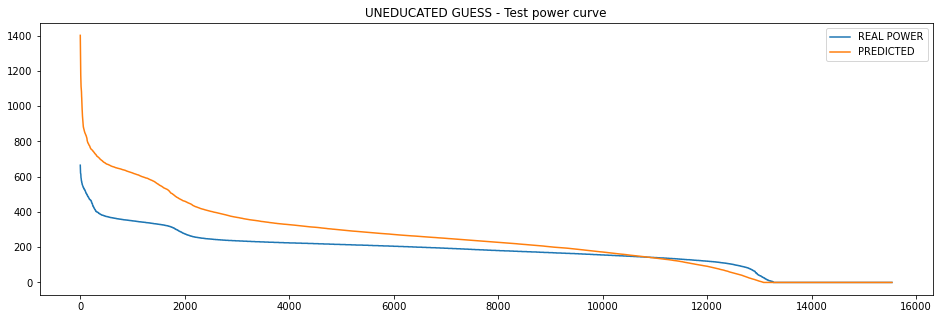

In [71]:
# Uneducated guess
print("RMSE: {:.2f}".format(root_mean_squared_error(y_train, X_train["estimated_power"])))
print("MAE: {:.2f}".format(mean_absolute_error(y_train, X_train["estimated_power"])))

plt.figure(figsize = (16, 5))
plt.plot(sorted(y)[::-1], label = "REAL POWER")
plt.plot(sorted(Xy["estimated_power"])[::-1], label = "PREDICTED")
plt.title("UNEDUCATED GUESS - Test power curve")
plt.legend()
plt.show()

<AxesSubplot:>

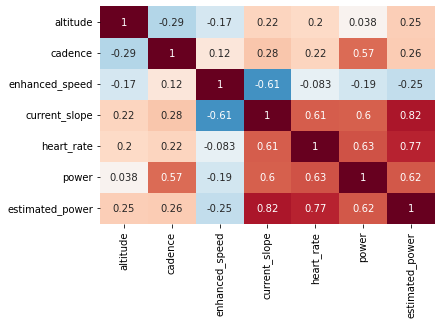

In [22]:
sns.heatmap(Xy.corr(), annot = True, cmap = "RdBu_r", vmin = -1, vmax = 1, cbar = False)

In [8]:
linreg = LinearRegression()

linreg.fit(X_train, y_train)

LinearRegression()

In [10]:
# Performance on training
print("R^2: {:.2f}".format(r2_score(y_train, ReLU(linreg.predict(X_train)))))
print("RMSE: {:.2f}".format(root_mean_squared_error(y_train, ReLU(linreg.predict(X_train)))))
print("MAE: {:.2f}".format(mean_absolute_error(y_train, ReLU(linreg.predict(X_train)))))
# print("MAPE: {:.2f} %".format(100*mean_absolute_percentage_error(y_train, ReLU(linreg.predict(X_train)))))
print()

# Performance on test
print("With ReLU")
print("\tR^2: {:.2f}".format(r2_score(y_test, ReLU(linreg.predict(X_test)))))
print("\tRMSE: {:.2f}".format(root_mean_squared_error(y_test, ReLU(linreg.predict(X_test)))))
print("\tMAE: {:.2f}".format(mean_absolute_error(y_test, ReLU(linreg.predict(X_test)))))
# print("MAPE: {:.2f} %".format(100*mean_absolute_percentage_error(y_test, ReLU(linreg.predict(X_test)))))
print()
print("Without ReLU")
print("\tR^2: {:.2f}".format(r2_score(y_test, linreg.predict(X_test))))
print("\tRMSE: {:.2f}".format(root_mean_squared_error(y_test, linreg.predict(X_test))))
print("\tMAE: {:.2f}".format(mean_absolute_error(y_test, linreg.predict(X_test))))
# print("MAPE: {:.2f} %".format(100*mean_absolute_percentage_error(y_test, linreg.predict(X_test))))

R^2: 0.65
RMSE: 63.30
MAE: 42.81

With ReLU
	R^2: 0.66
	RMSE: 62.76
	MAE: 42.34

Without ReLU
	R^2: 0.65
	RMSE: 63.50
	MAE: 44.32


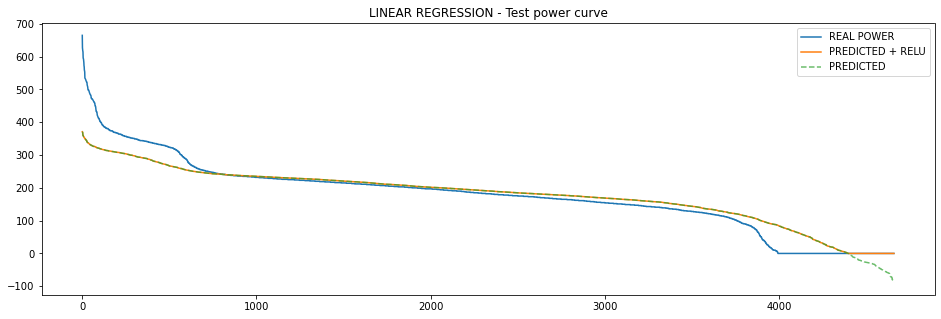

In [78]:
plt.figure(figsize = (16, 5))
plt.plot(sorted(y_test)[::-1], label = "REAL POWER")
plt.plot(sorted(ReLU(linreg.predict(X_test)))[::-1], label = "PREDICTED + RELU")
plt.plot(sorted(linreg.predict(X_test))[::-1], label = "PREDICTED", alpha = .7, ls = "--")
plt.title("LINEAR REGRESSION - Test power curve")
plt.legend()
plt.show()

Tree Train RMSE: 0.6034



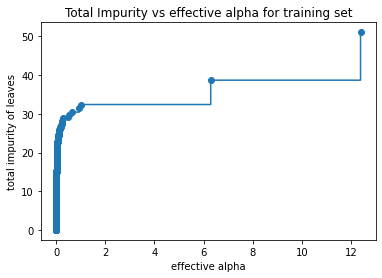

Fitting 3 folds for each of 5 candidates, totalling 15 fits
With ReLU
RMSE: 38.82
MAE: 21.82

Without ReLU
RMSE: 38.82
MAE: 21.82


In [12]:
# Initialize a Decision Tree Classifier

d3 = DecisionTreeRegressor(random_state = 101, criterion = "absolute_error")
d3.fit(X_train, y_train)
print("Tree Train RMSE: {:.4f}\n".format((root_mean_squared_error(y_train, d3.predict(X_train)))))

# Compute impurities to look for an adequate pruning term
path = d3.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
# Plot the impurity level given ccp_alpha
plt.plot(ccp_alphas[:-1], impurities[:-1], marker = "o", drawstyle = "steps-post")
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")
plt.title("Total Impurity vs effective alpha for training set")
plt.show()

# Tree Pruning (we are overfitting - Accuracy: 100% in training)
tree_params = {"ccp_alpha":[ccp_alphas[impurities < impty].max()
                            for impty in np.linspace(0.1, np.round(impurities.max()/2, 3),
                                                     num = 5)]}

tree_grid = GridSearchCV(DecisionTreeRegressor(random_state = 101, criterion = "absolute_error"),
                         tree_params, cv = 3, n_jobs = 6, verbose = 10,
                         return_train_score = True)
tree_grid.fit(X_train, y_train)

# Show the results
print("With ReLU")
print("RMSE: {:.2f}".format(root_mean_squared_error(y_test, ReLU(tree_grid.best_estimator_.predict(X_test)))))
print("MAE: {:.2f}".format(mean_absolute_error(y_test, ReLU(tree_grid.best_estimator_.predict(X_test)))))
# print("MAPE: {:.2f} %".format(100*mean_absolute_percentage_error(y_test, ReLU(tree_grid.best_estimator_.predict(X_test)))))
print()
print("Without ReLU")
print("RMSE: {:.2f}".format(root_mean_squared_error(y_test, tree_grid.best_estimator_.predict(X_test))))
print("MAE: {:.2f}".format(mean_absolute_error(y_test, tree_grid.best_estimator_.predict(X_test))))
# print("MAPE: {:.2f} %".format(100*mean_absolute_percentage_error(y_test, tree_grid.best_estimator_.predict(X_test))))

In [13]:
X.shape

(15539, 6)

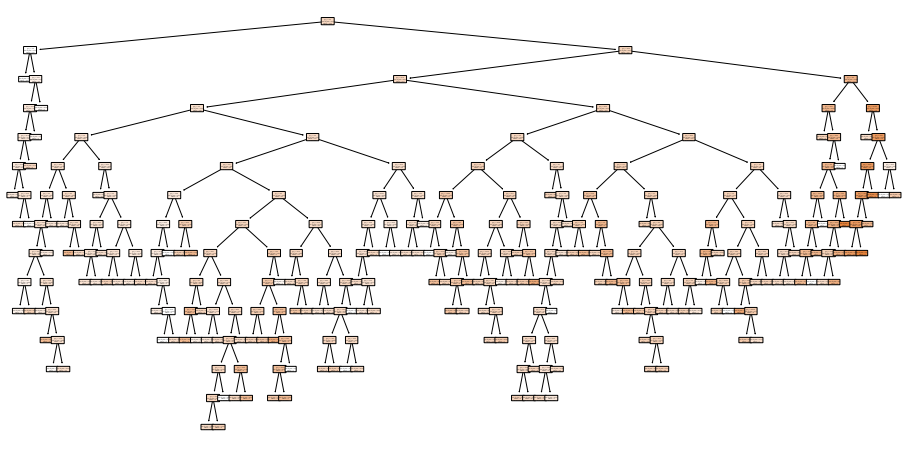

In [20]:
# tree.plot_tree(d3)
# plt.show()

fig_dpath, axes_dpath = plt.subplots(nrows = 1,ncols = 1,figsize = (16, 8))
tree.plot_tree(tree_grid.best_estimator_, filled = True, rounded = True, ax = axes_dpath)
plt.savefig('tree_grid_best_estimator_dpath.svg')#, dpi = 3000)

In [59]:
def predict_from_tree(tree, feature_names, instance):
    node = 0  # start from the root
    while tree.children_left[node] != -1:  # while not a leaf
        feature_index = tree.feature[node]
        threshold = tree.threshold[node]
        
        if instance.iloc[feature_index] <= threshold:
            node = tree.children_left[node]
        else:
            node = tree.children_right[node]
    
    # When a leaf is reached
    return tree.value[node][0, 0]

# Example usage
instance = X.iloc[100]  # An instance to predict
prediction = predict_from_tree(tree_grid.best_estimator_.tree_, X.columns, instance)
print(f"Predicted value: {prediction}")

Predicted value: 136.0


In [69]:
tree_grid.best_estimator_.tree_.children_right

array([ 14,   3,  -1,  13,  12,  11,   8,  -1,  10,  -1,  -1,  -1,  -1,
        -1, 254, 141,  54,  39,  34,  33,  32,  25,  24,  -1,  -1,  27,
        -1,  29,  -1,  31,  -1,  -1,  -1,  -1,  36,  -1,  38,  -1,  -1,
        41,  -1,  47,  46,  45,  -1,  -1,  -1,  51,  50,  -1,  -1,  53,
        -1,  -1, 124,  69,  66,  65,  60,  -1,  62,  -1,  64,  -1,  -1,
        -1,  68,  -1,  -1, 105,  92,  77,  76,  75,  -1,  -1,  -1,  81,
        80,  -1,  -1,  91,  88,  87,  86,  -1,  -1,  -1,  90,  -1,  -1,
        -1, 104,  97,  96,  -1,  -1,  99,  -1, 103, 102,  -1,  -1,  -1,
        -1, 111, 108,  -1, 110,  -1,  -1, 115, 114,  -1,  -1, 123, 120,
       119,  -1,  -1, 122,  -1,  -1,  -1, 136, 133, 132, 129,  -1, 131,
        -1,  -1,  -1, 135,  -1,  -1, 140, 139,  -1,  -1,  -1, 195, 174,
       157, 150, 147,  -1, 149,  -1,  -1, 152,  -1, 156, 155,  -1,  -1,
        -1, 169, 166, 161,  -1, 163,  -1, 165,  -1,  -1, 168,  -1,  -1,
       171,  -1, 173,  -1,  -1, 176,  -1, 194, 193, 192, 191, 18

In [58]:
tree_grid.best_estimator_.predict(pd.DataFrame(X.iloc[100]).T)

array([136.])

In [ ]:
y_test.shape, tree_grid.best_estimator_.predict(X_test).shape

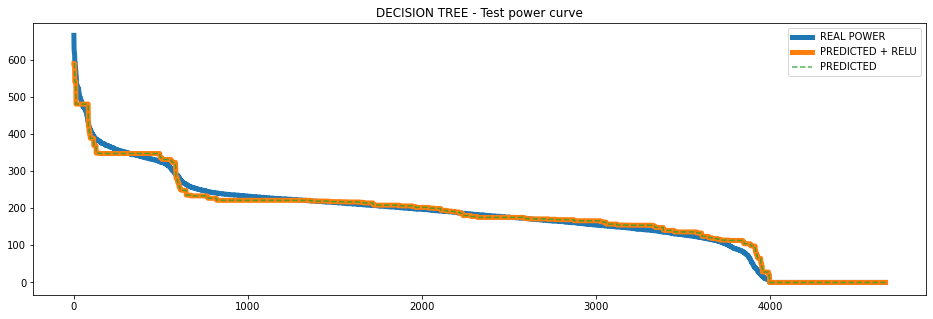

In [127]:
plt.figure(figsize = (16, 5))
plt.plot(sorted(y_test)[::-1], label = "REAL POWER", lw = 5)
plt.plot(sorted(ReLU(tree_grid.best_estimator_.predict(X_test)))[::-1], label = "PREDICTED + RELU", lw = 5)
plt.plot(sorted(tree_grid.best_estimator_.predict(X_test))[::-1], label = "PREDICTED", alpha = .8, ls = "--")
plt.title("DECISION TREE - Test power curve")
plt.legend()
plt.show()

In [130]:
model = Sequential(name = "MLP")
model.add(Dense(input_dim = 6, units = 6, activation = "softplus", name = "dense_1"))
model.add(Dense(units = 30, activation = "softplus", name = "dense_2"))
model.add(Dense(units = 30, activation = "softplus", name = "dense_3"))
model.add(Dense(units = 30, activation = "softplus", name = "dense_4"))
model.add(Dense(units = 30, activation = "softplus", name = "dense_5"))
model.add(Dense(units = 1, activation = None, name = "dense_6"))
model.compile(loss = "mean_absolute_error", optimizer = "adam",
              metrics = ["mean_absolute_error"])
model.summary()

## Define an Early Stopping
early_stopping = EarlyStopping(monitor = "mean_absolute_error",
                               mode = "min", patience = 20, verbose = 1)

history = model.fit(X_train, y_train, epochs = 300, batch_size = 200,
                    verbose = 0, validation_split = 0.4, callbacks = [early_stopping])

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6)                 42        
                                                                 
 dense_2 (Dense)             (None, 30)                210       
                                                                 
 dense_3 (Dense)             (None, 30)                930       
                                                                 
 dense_4 (Dense)             (None, 30)                930       
                                                                 
 dense_5 (Dense)             (None, 30)                930       
                                                                 
 dense_6 (Dense)             (None, 1)                 31        
                                                                 
Total params: 3,073
Trainable params: 3,073
Non-trainable param

<AxesSubplot:>

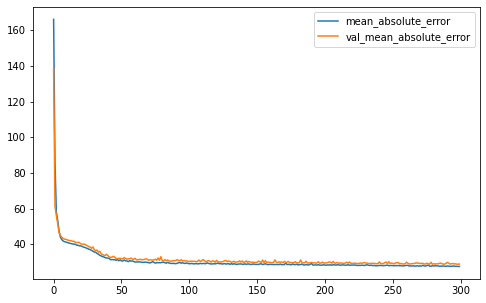

In [124]:
pd.DataFrame(history.history)[["mean_absolute_error", "val_mean_absolute_error"]].plot(figsize = (8, 5))

In [125]:
print("With ReLU")
print("\tRMSE: {:.2f}".format(root_mean_squared_error(y_test, ReLU(model.predict(X_test)))))
print("\tMAE: {:.2f}".format(mean_absolute_error(y_test, ReLU(model.predict(X_test)))))
print("\tMAPE: {:.2f} %".format(100*mean_absolute_percentage_error(y_test, ReLU(model.predict(X_test)))))
print()
print("Without ReLU")
print("\tRMSE: {:.2f}".format(root_mean_squared_error(y_test, model.predict(X_test))))
print("\tMAE: {:.2f}".format(mean_absolute_error(y_test, model.predict(X_test))))
print("\tMAPE: {:.2f} %".format(100*mean_absolute_percentage_error(y_test, model.predict(X_test))))

With ReLU
146/146 [==============================] - 0s 1ms/step
	RMSE: 48.04
146/146 [==============================] - 0s 1ms/step
	MAE: 28.35
146/146 [==============================] - 0s 1ms/step
	MAPE: 1253689499672476672.00 %

Without ReLU
146/146 [==============================] - 0s 1ms/step
	RMSE: 48.04
146/146 [==============================] - 0s 1ms/step
	MAE: 28.35
146/146 [==============================] - 0s 1ms/step
	MAPE: 1253689499672476672.00 %


146/146 [==============================] - 0s 1ms/step


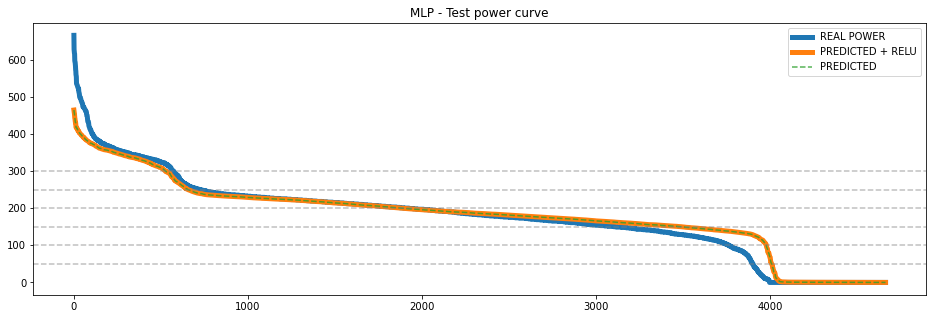

In [129]:
plt.figure(figsize = (16, 5))
plt.plot(sorted(y_test)[::-1], label = "REAL POWER", lw = 5)
plt.plot(sorted(ReLU(model.predict(X_test)))[::-1], label = "PREDICTED + RELU", lw = 5)
plt.plot(sorted(model.predict(X_test))[::-1], label = "PREDICTED", alpha = .8, ls = "--")
for ix in [50, 100, 150, 200, 250, 300]:
    plt.axhline(ix, ls = "--", color = "grey", alpha = .5)
plt.title("MLP - Test power curve")
plt.legend()
plt.show()

In [ ]:
def relu(x):
    return np.maximum(0, x)
def sofplus(x):
    return np.log(np.exp(x) + 1)
def linear(x):
    return x

def predict_from_keras(weights, instance):
    output = instance
    for w, b in weights[:-1]:  # Apply all layers except the last
        output = relu(np.dot(output, w) + b)
    
    # Apply the last layer (assumed to be linear for regression)
    w, b = weights[-1]
    output = linear(np.dot(output, w) + b)
    
    return output[0]  # Since the output will be an array with one element

# Example usage
instance = X_test[0]  # An instance to predict
prediction = predict_from_keras(weights, instance)
print(f"Predicted value: {prediction}")